In [1]:
%cd ../src

/home/ubuntu/SPVD_Lightning/src


In [2]:
from datasets.shapenet.shapenet_loader import ShapeNet

categories = ['chair']
path = "../data/ShapeNet"

te = ShapeNet(path, "test", 2048, categories, load_renders=True)

Loading (test) renders for chair (03001627): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1317/1317 [00:35<00:00, 36.97it/s]


In [5]:
import torch

model_params = torch.load("../checkpoints/ShapeNet/chair-100.ckpt", weights_only=True)
down_blocks = model_params["down_blocks"]
up_blocks = model_params["up_blocks"]

t_emb_features = 64

from my_models.spvd import SPVUnet
model = SPVUnet(down_blocks, up_blocks, t_emb_features)

from my_models.lightning_base import DiffusionBase
model = DiffusionBase(model, lr=1e-4)
model.load_state_dict(model_params["state_dict"])
model = model.cuda().eval()

In [6]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler

ddpm_sched = DDPMSparseScheduler(beta_min=0.0001, beta_max=0.02, steps=1024)

In [7]:
samples = 16
test_images = iter(te)
references = [next(test_images) for _ in range(samples)]
reference_images = torch.stack([r["render-features"] for r in references]).to("cuda")

In [ ]:
preds = ddpm_sched.sample(model, 16, 2048, reference=None)

Sampling:   6%|█████████▍                                                                                                                                                  | 62/1024 [00:12<02:57,  5.41it/s]

In [13]:
from utils.visualization import display_pointclouds_grid
display_pointclouds_grid(preds.cpu().numpy(), offset=8, point_size=0.3)

Output()

In [9]:
real = torch.stack([r["pc"] for r in references]).numpy()
display_pointclouds_grid(real, offset=8, point_size=0.3)

Output()

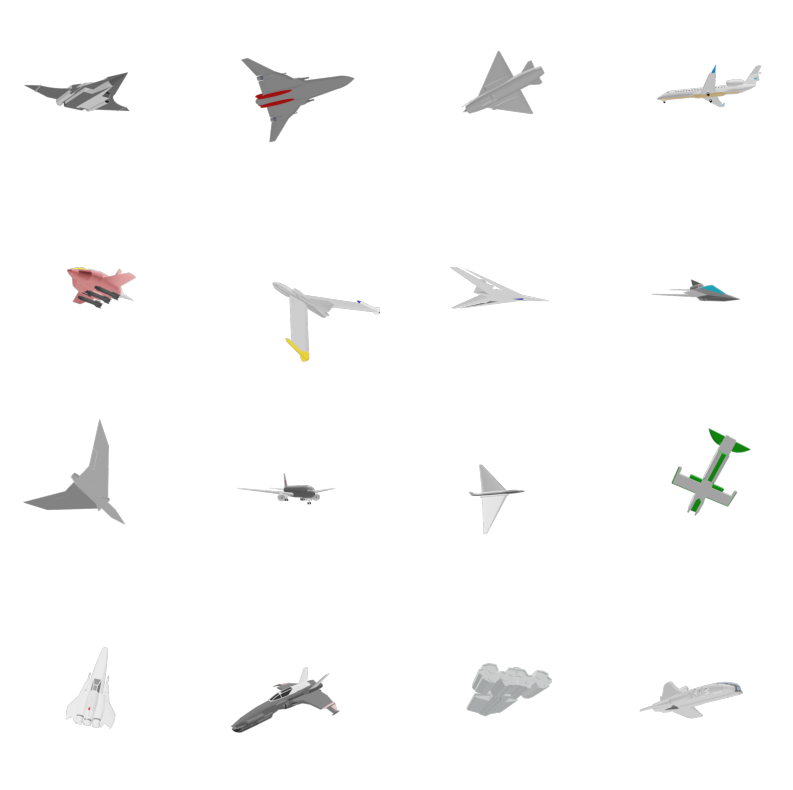

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        ax.axis('off')
        idx = i * 4 + j
        view = references[idx]["selected-view"]
        file = references[idx]["filename"]

        img = mpimg.imread(f"../data/ShapeNet/renders/{file}/00{view}.png")
        ax.imshow(img)